In [76]:
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *

# Fit functions

In [100]:
def coherent_state(n, alpha):
    return exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def fitgausssum_with_baseline(xdata,ydata,fitparams=None,domain=None,showfit=False,
                              showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def expfunc2(p,x):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*math.e**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

# def expfunc(x,b,c,d):
#     """p[0]*exp(-(x-p[1])/p[2])"""
#     return b*math.e**(-(x-c)/d) 

def expfunc_test(x,b,c):
    return b * math.e**(-x/c)

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(a, b, c, d):
    ran = 0.2
    numbins = 200
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    fig.tight_layout()

    axs[0].scatter(a, b, label='g', color='b', marker='*')
    axs[0].scatter(c, d, label='e', color='r', marker='*')
    
    xg, yg = np.median(a), np.median(b)
    xe, ye = np.median(c), np.median(d)
    
    axs[0].scatter(xg, yg, color='k', marker='o')
    axs[0].scatter(xe, ye, color='k', marker='o')
    axs[0].set_xlabel('I (a.u.)')
    axs[0].set_ylabel('Q (a.u.)')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Unrotated')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = a*cos(theta) - b*sin(theta)
    qg_new = a*sin(theta) + b*cos(theta) 
    ie_new = c*cos(theta) - d*sin(theta)
    qe_new = c*sin(theta) + d*cos(theta)
    
    axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
    axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    axs[1].scatter(xg, yg, color='k', marker='o')
    axs[1].scatter(xe, ye, color='k', marker='o')    
    axs[1].set_xlabel('I (a.u.)')
#     axs[1].set_ylabel('Q (a.u.)')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Rotated')
    """X and Y ranges for histogram"""
    xlims = [xg-ran/5, xg+ran/5]
    ylims = [yg-ran/5, yg+ran/5]

    ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
    
    axs[2].set_xlabel('I(a.u.)')
    fig.show()
    return fid, theta

# Resonator spectroscopy

fits =  [2.47429690e-03 2.37049128e-02 8.05182844e+00 7.97865927e-04]


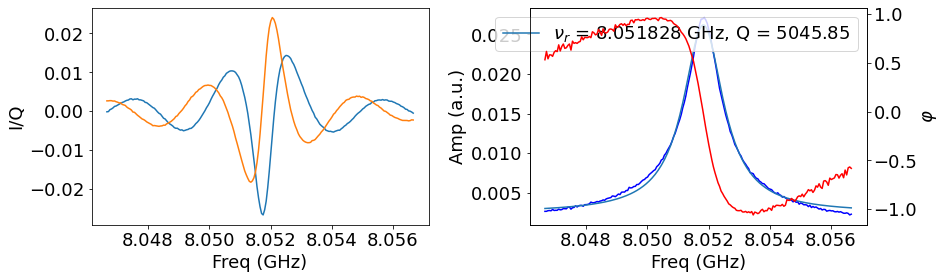

In [123]:
expt_name = 'resonator_spec'
filelist = [0]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

# Qubit ge spectroscopy

fits =  [-2.53528334e-02  1.81586693e-03  4.74691305e+00  8.98604266e-04]


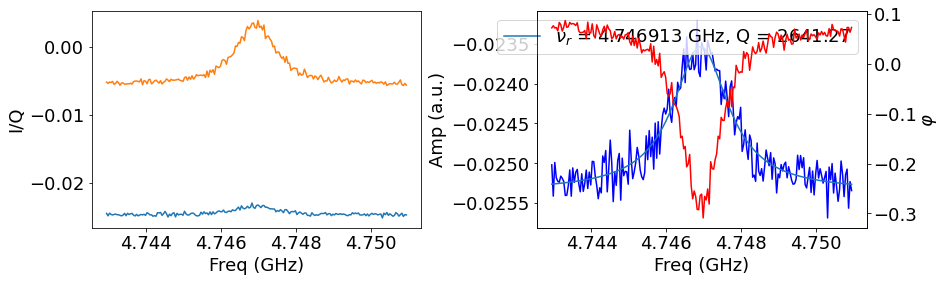

In [126]:
expt_name = 'ge_spectroscopy'
filelist = [0]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = -np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

# Ramsey

Original qubit frequency choice = 4.746942812186551 GHz
Oscillation freq =  0.0989423086014202  MHz
Offset freq = 0.0010576913985798075 MHz
Suggested qubit frequency choice = 4.746943869877949 GHz
T2* = 117.02825247568352 us
Original qubit frequency choice = 4.746943770437629 GHz
Oscillation freq =  0.10284516664323157  MHz
Offset freq = -0.0028451666432315614 MHz
Suggested qubit frequency choice = 4.7469409252709855 GHz
T2* = 126.25858507921092 us
Original qubit frequency choice = 4.7469409252709855 GHz
Oscillation freq =  0.0985149628093314  MHz
Offset freq = 0.0014850371906686005 MHz
Suggested qubit frequency choice = 4.7469424103081765 GHz
T2* = 115.62364212298921 us


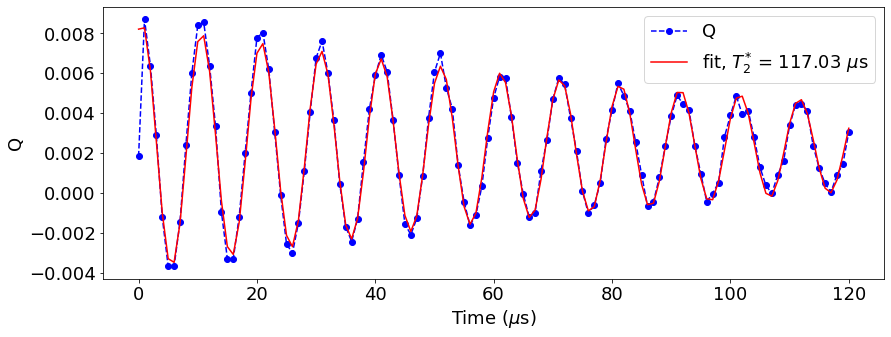

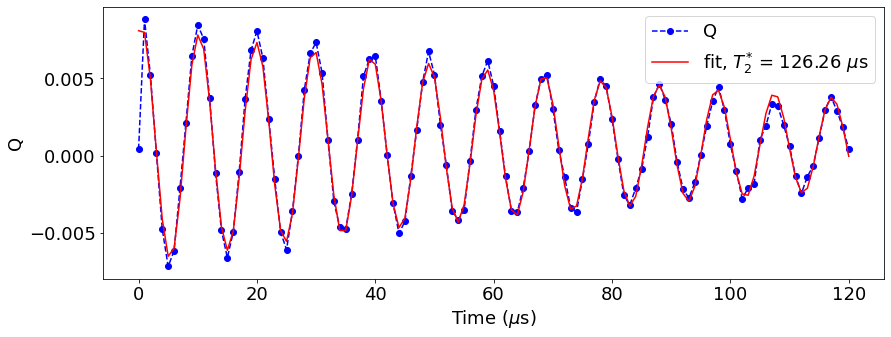

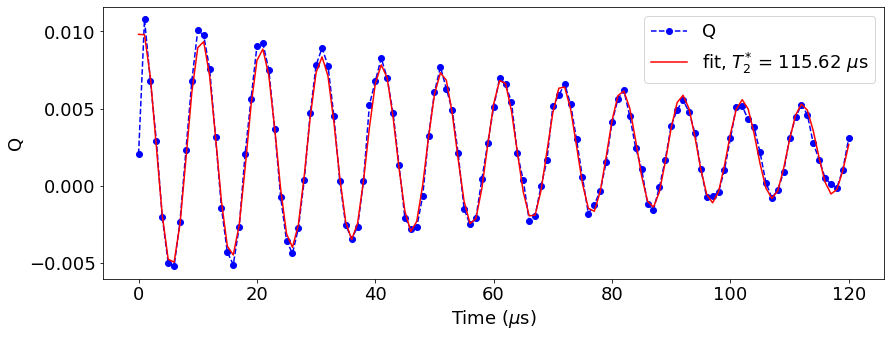

In [131]:
expt_name = 'Ramsey'
filelist = [0, 3, 4]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

#         P = np.sqrt(I**2 + Q**2)
        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()


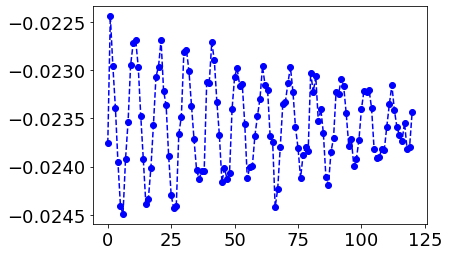

In [133]:
plt.plot(I, 'bo--')

# Power Rabi

Suggested π amp =  0.3335156468668881
Suggested π amp =  0.35114640865853564
Suggested π amp =  0.35176241396502655
Suggested π amp =  0.3535422258124077


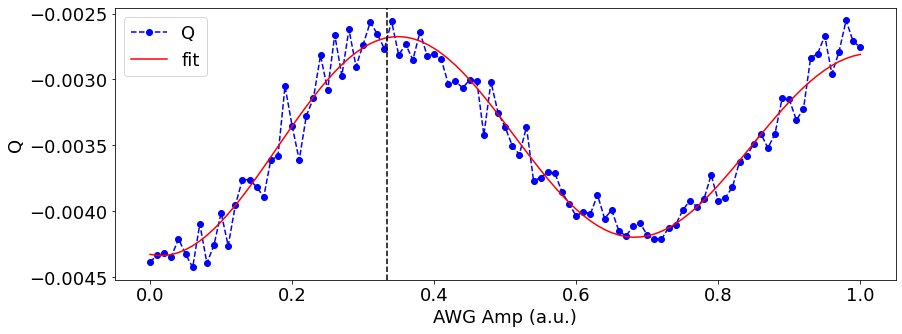

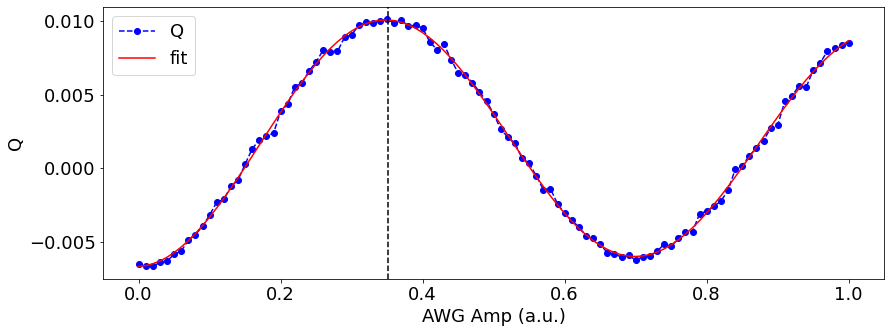

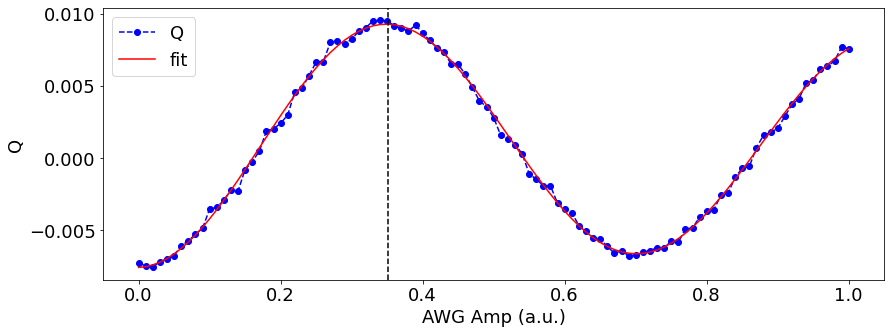

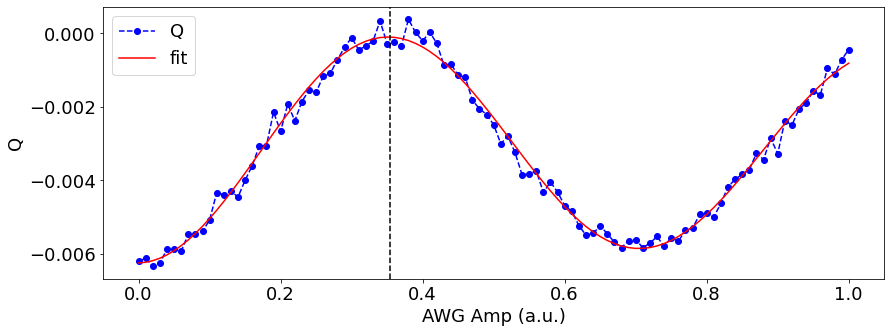

In [135]:
expt_name = 'power_rabi'
filelist = [0, 1, 2, 3]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

#         y =(I**2 + Q**2)
        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = ", 1/2/p[1])
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()


# T1

T1: 92.084 μs
T1: 95.303 μs
T1: 89.261 μs


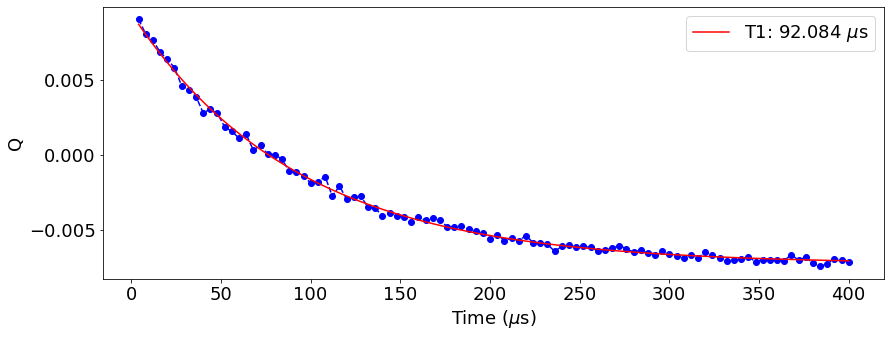

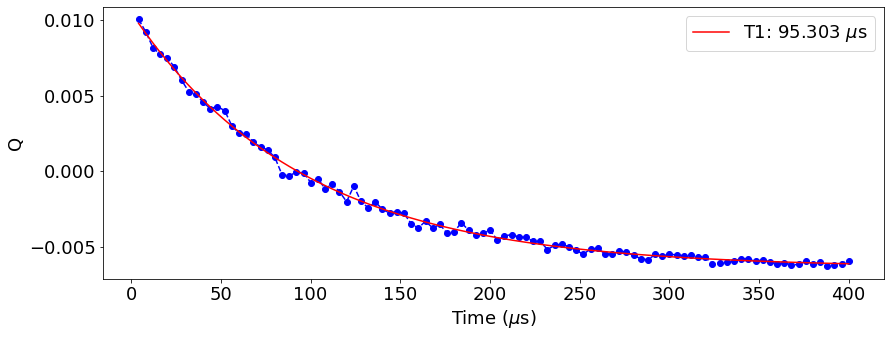

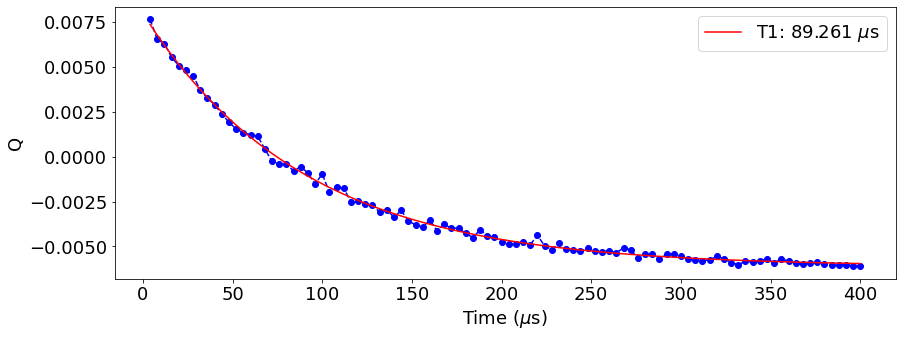

In [136]:
expt_name = 't1'
filelist = [0, 1, 2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()


# Histogram 

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.109
Optimal fidelity after rotation = 0.881


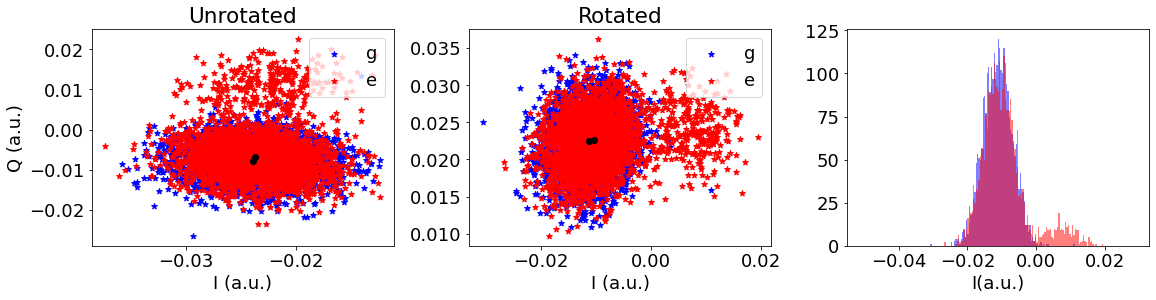

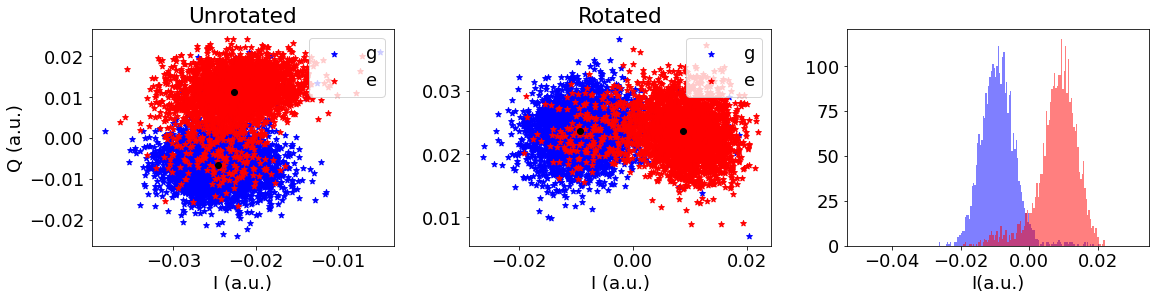

In [107]:
expt_name = 'histogram'
filelist = [0, 1]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = array(a['ig'])
        qg = array(a['qg'])
        ie = array(a['ie'])
        qe = array(a['qe'])
        a.close()
    fid, angle = hist(ig, qg, ie, qe)

    print('Optimal fidelity after rotation = %.3f'%fid)

## JPA

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.907
Optimal fidelity after rotation = 0.908
Optimal fidelity after rotation = 0.913


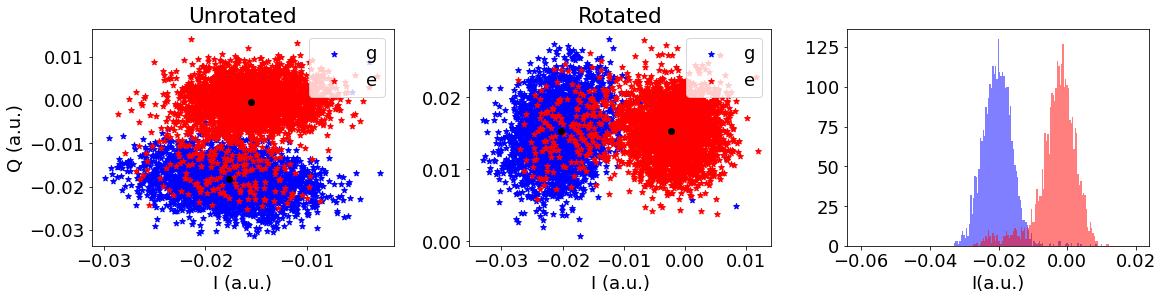

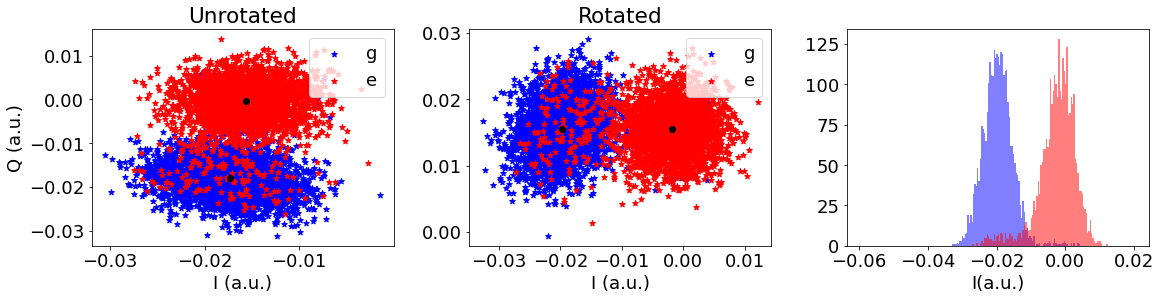

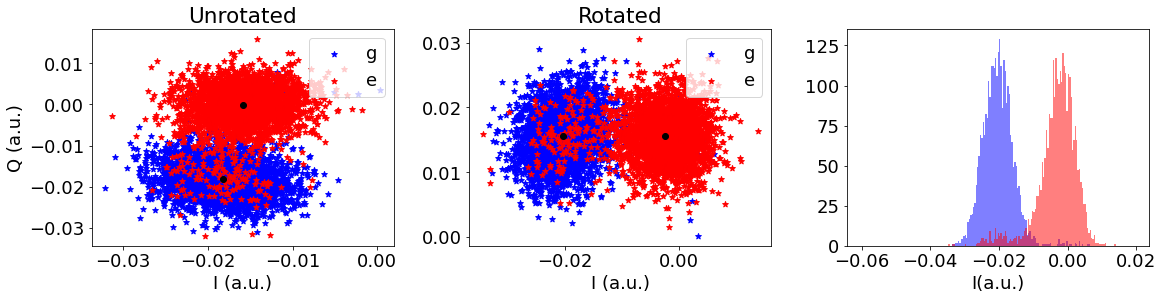

In [128]:
expt_name = 'histogram_jpa'
filelist = [0, 1, 2]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = array(a['ig'])
        qg = array(a['qg'])
        ie = array(a['ie'])
        qe = array(a['qe'])
        a.close()
    fid, angle = hist(ig, qg, ie, qe)

    print('Optimal fidelity after rotation = %.3f'%fid)